In [69]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We will load all the images from the train, val, and test folders. With flow_from_directory, the images will have the labels attached so we do not need to specify the labels.

I have also moved some of the train images into the val folder since there was a pretty large imbalance. There were only around 10 images in the validation set.

I will also augment some of the images when we pull them in to prevent overfitting and potentially help more with the imbalance in the data

In [ ]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255, rotation_range=40, zoom_range=0.3, horizontal_flip=True,
                                width_shift_range=0.25, height_shift_range=0.25)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)
#train_labels = to_categorical(train_img.labels, num_classes=2)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#val_labels = to_categorical(val_img.labels, num_classes=2)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#test_labels = to_categorical(test_img.labels, num_classes=2)
print(train_img.class_indices)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


After tinkering with the data, it seems that include 'class_mode=binary' in the flow from directory function caused the model to work properly. Without it, the test accuracy and validation accuracy was exactly 0.5 for each epoch.

# Model 1
Here we will make a pretty shallow network to see how well it will work. Despite the images looking like grayscale, they are still 3 channel(rgb).

In [130]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [132]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_hist = model.fit(train_img, 
                       epochs=10, 
                       validation_data=val_img, 
                       steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 119s 796ms/step - loss: 0.6769 - accuracy: 0.8535 - val_loss: 30.8740 - val_accuracy: 0.5000
Epoch 2/10
150/150 [==============================] - 119s 793ms/step - loss: 0.2652 - accuracy: 0.8850 - val_loss: 27.1030 - val_accuracy: 0.5000
Epoch 3/10
150/150 [==============================] - 119s 791ms/step - loss: 0.2312 - accuracy: 0.9030 - val_loss: 4.2252 - val_accuracy: 0.6250
Epoch 4/10
150/150 [==============================] - 118s 788ms/step - loss: 0.2039 - accuracy: 0.9128 - val_loss: 0.4310 - val_accuracy: 0.8125
Epoch 5/10
150/150 [==============================] - 118s 786ms/step - loss: 0.2102 - accuracy: 0.9170 - val_loss: 1.3040 - val_accuracy: 0.5677
Epoch 6/10
150/150 [==============================] - 118s 787ms/step - loss: 0.1841 - accuracy: 0.9268 - val_loss: 0.6230 - val_accuracy: 0.6823
Epoch 7/10
150/150 [==============================] - 119s 790ms/step - loss: 0.1751 - accuracy: 0.9285 - val_loss: 1.8846

When we evaluate on the test set, we see that the accuracy is not too great, not even 70 percent

In [133]:
model.evaluate(test_img)

20/20 [==============================] - 5s 240ms/step - loss: 0.8962 - accuracy: 0.6619


[0.896195650100708, 0.6618589758872986]

NameError: name 'model_hist' is not defined

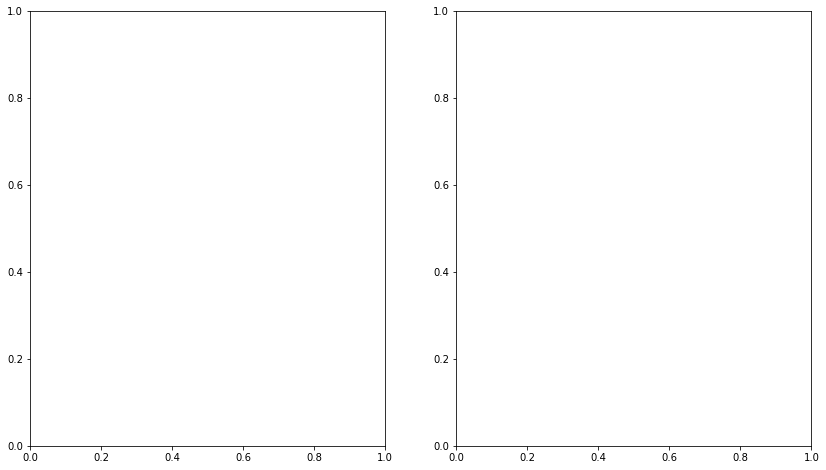

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 8))

ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch');

With this network, we can see that the model is not generalizing very well. While the test accuracy is pretty ok, the validation accuracy is very sporadic and also not matching the test accuracy, so it is overfitting.


# Model 2
We see from the graphs that the model is very sporadic. We will try to fix this and improve the test accuracy by adding deeper layers. We will also bath normalize and add dropout to the layers.
The data augmentation will be altered slightly to see if performance is any better.

In [ ]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

In [135]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(units=1, activation='sigmoid'))

In [136]:
model2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_37 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 109, 109, 64)      0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 54, 54, 64)      

We will monitor the accuracy and decrease learning rate if the accuracy plateaus

In [137]:
optimizer = keras.optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

model2.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model2_hist = model2.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch=150, callbacks=[reduce_lr, early_stop])

Epoch 1/10
150/150 [==============================] - 161s 1s/step - loss: 0.3385 - accuracy: 0.8424 - val_loss: 10.7092 - val_accuracy: 0.5000
Epoch 2/10
150/150 [==============================] - 159s 1s/step - loss: 0.2479 - accuracy: 0.8871 - val_loss: 19.7878 - val_accuracy: 0.5000
Epoch 3/10
150/150 [==============================] - 159s 1s/step - loss: 0.2249 - accuracy: 0.9076 - val_loss: 14.2776 - val_accuracy: 0.5000
Epoch 4/10
150/150 [==============================] - 159s 1s/step - loss: 0.1881 - accuracy: 0.9231 - val_loss: 4.3011 - val_accuracy: 0.5000
Epoch 5/10
150/150 [==============================] - 160s 1s/step - loss: 0.1923 - accuracy: 0.9252 - val_loss: 0.7220 - val_accuracy: 0.7656
Epoch 6/10
150/150 [==============================] - 160s 1s/step - loss: 0.1806 - accuracy: 0.9287 - val_loss: 0.3871 - val_accuracy: 0.8802
Epoch 7/10
150/150 [==============================] - 160s 1s/step - loss: 0.1737 - accuracy: 0.9327 - val_loss: 0.2991 - val_accuracy: 0.8

In [139]:
model2.evaluate(test_img)

20/20 [==============================] - 5s 256ms/step - loss: 0.5119 - accuracy: 0.8574


[0.5119263529777527, 0.8573718070983887]

Here we can see that the model has improved in accuracy a fair amount, but still lacking. We can plot and see how it performed over the epochs.

Text(0.5, 1.0, 'Model Loss')

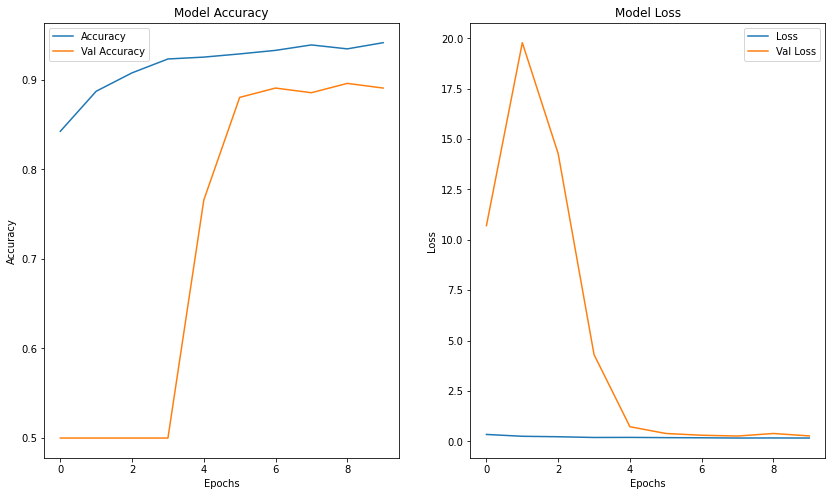

In [140]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model2_hist.history['accuracy'])
ax1.plot(model2_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model2_hist.history['loss'])
ax2.plot(model2_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Model 3
While the performance has increased, we can see there is still some overfitting. It is also not quite clear why the validation accuracy is stagnant for the first 3 epochs, and the validation loss skyrockets during the first 1-2 epochs. 

What I will try next is to add more regularization and more data augmentation to help with overfitting.

In [66]:
#Change batch size depending on scenario
b_size =  16

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.15, height_shift_range=0.15)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Test model

In [ ]:
modelt = Sequential()
modelt.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelt.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelt.add(Dropout(0.1))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelt.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelt.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelt.add(Dropout(0.2))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelt.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelt.add(Dropout(0.2))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelt.add(Flatten())
modelt.add(Dense(units = 128 , activation = 'relu'))
modelt.add(Dropout(0.2))
modelt.add(Dense(units = 1 , activation = 'sigmoid'))

In [57]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

modelt.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
modelt_hist = modelt.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch= 5040/b_size, callbacks=[reduce_lr, early_stop])

Epoch 1/10
315/315 [==============================] - 120s 382ms/step - loss: 0.5140 - accuracy: 0.8369 - val_loss: 36.1730 - val_accuracy: 0.5000
Epoch 2/10
315/315 [==============================] - 117s 371ms/step - loss: 0.3067 - accuracy: 0.8871 - val_loss: 1.1314 - val_accuracy: 0.6823
Epoch 3/10
315/315 [==============================] - 105s 332ms/step - loss: 0.2619 - accuracy: 0.9111 - val_loss: 0.5133 - val_accuracy: 0.7760
Epoch 4/10
315/315 [==============================] - 107s 338ms/step - loss: 0.2558 - accuracy: 0.9103 - val_loss: 0.2758 - val_accuracy: 0.9219
Epoch 5/10
315/315 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9212
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
315/315 [==============================] - 136s 433ms/step - loss: 0.2486 - accuracy: 0.9212 - val_loss: 0.5807 - val_accuracy: 0.8073
Epoch 6/10
315/315 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9409
Epoch 0

In [58]:
modelt.evaluate(test_img)

39/39 [==============================] - 6s 144ms/step - loss: 0.3441 - accuracy: 0.9087


[0.3441269099712372, 0.9086538553237915]

Text(0.5, 1.0, 'Model Loss')

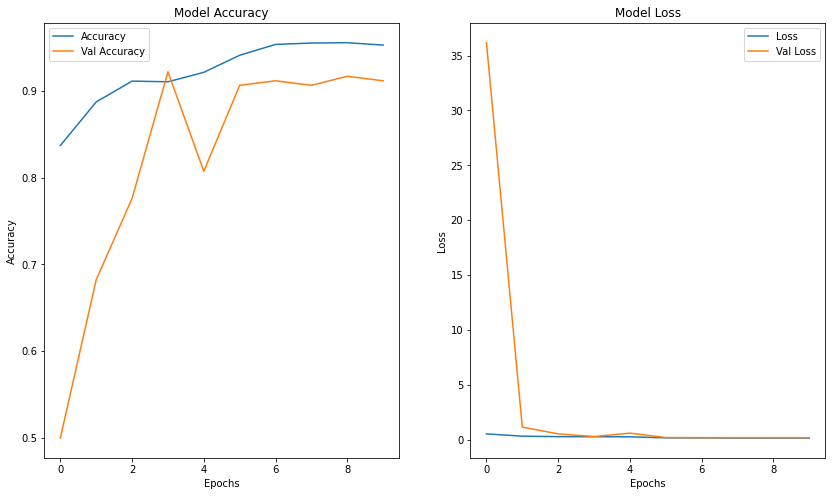

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(modelt_hist.history['accuracy'])
ax1.plot(modelt_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(modelt_hist.history['loss'])
ax2.plot(modelt_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Real Model

In [70]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3), groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(GlobalAveragePooling2D())
model3.add(Dense(units=128, activation='relu', kernel_regularizer=L2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(units=1, activation='sigmoid'))

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model3.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model3_hist = model3.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch= 5040/b_size, callbacks=[reduce_lr, early_stop])

Epoch 1/10
315/315 [==============================] - 100s 318ms/step - loss: 0.8815 - accuracy: 0.8635 - val_loss: 6.0464 - val_accuracy: 0.5000
Epoch 2/10
315/315 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.8891
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
315/315 [==============================] - 104s 329ms/step - loss: 0.3330 - accuracy: 0.8891 - val_loss: 4.8848 - val_accuracy: 0.5000
Epoch 3/10
315/315 [==============================] - 105s 334ms/step - loss: 0.2543 - accuracy: 0.9111 - val_loss: 0.7317 - val_accuracy: 0.6094
Epoch 4/10
315/315 [==============================] - 117s 371ms/step - loss: 0.2197 - accuracy: 0.9242 - val_loss: 0.2581 - val_accuracy: 0.9115
Epoch 5/10
315/315 [==============================] - 112s 354ms/step - loss: 0.2058 - accuracy: 0.9302 - val_loss: 0.3186 - val_accuracy: 0.9271
Epoch 6/10
315/315 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9333
Epoch 00

In [73]:
model3.evaluate(test_img)

39/39 [==============================] - 5s 141ms/step - loss: 0.3098 - accuracy: 0.8846


[0.3097585439682007, 0.8846153616905212]

Text(0.5, 1.0, 'Model Loss')

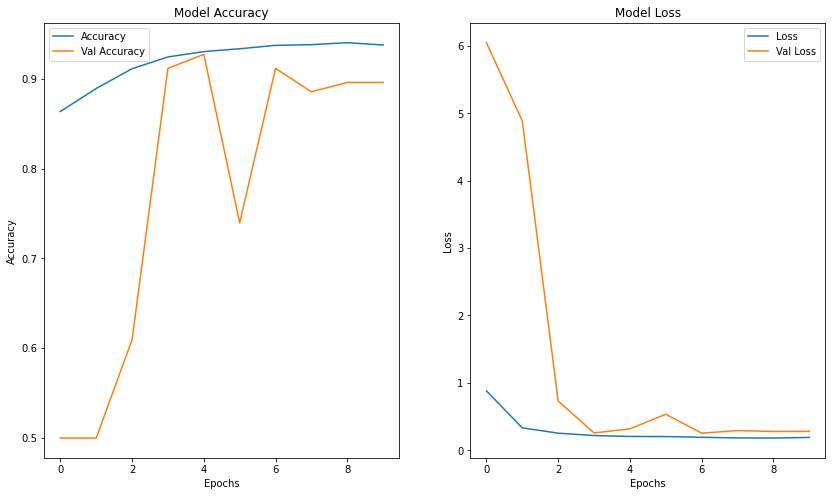

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model3_hist.history['accuracy'])
ax1.plot(model3_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model3_hist.history['loss'])
ax2.plot(model3_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Model 4
The accuracy and val accuracy are in line with one another, which means that there is no more overfitting. But the accuracy number itself is still under 90%, which is not ideal.

Now that a wall has been hit with my own model, I will explore using other models that have already been trained and perform extremely well. First, starting with VGG16. It turns out that adam optimizer does not work well with VGG16 so we will use SGD.

I will also try doubling the batch size since VGG takes such a long time to run

In [ ]:
#Change batch size depending on scenario
b_size =  32

train_data = ImageDataGenerator(rescale=1/255, rotation_range=40, zoom_range=0.4, horizontal_flip=True,
                                width_shift_range=0.35, height_shift_range=0.35)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
model4 = Sequential()
model4.add(VGG16(include_top = False, input_shape=(224, 224, 3)))

model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.SGD(lr=0.0001, clipnorm=1.0)
model4.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model4_hist = model4.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch=5040/b_size)

Epoch 1/5
79/78 [==============================] - 1391s 18s/step - loss: 0.6629 - accuracy: 0.6008 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/5
79/78 [==============================] - 1393s 18s/step - loss: 0.5598 - accuracy: 0.7514 - val_loss: 0.7417 - val_accuracy: 0.5000
Epoch 3/5
79/78 [==============================] - 1334s 17s/step - loss: 0.5371 - accuracy: 0.7514 - val_loss: 0.7204 - val_accuracy: 0.5000
Epoch 4/5
79/78 [==============================] - 1150s 15s/step - loss: 0.5171 - accuracy: 0.7514 - val_loss: 0.6799 - val_accuracy: 0.5000
Epoch 5/5
79/78 [==============================] - 1250s 16s/step - loss: 0.4995 - accuracy: 0.7516 - val_loss: 0.6394 - val_accuracy: 0.5052
